![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [33]:
# Start your code here!
# import pandas as pd

EDA

In [34]:
# Determining the column names, data types, and values
import pandas as pd
import pingouin as pg
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

women = pd.read_csv('women_results.csv', index_col=0)
men = pd.read_csv('men_results.csv', index_col=0)
print(women.head(), '\n')
print(men.head())

         date home_team  away_team  home_score  away_score        tournament
0  1969-11-01     Italy     France           1           0              Euro
1  1969-11-01   Denmark    England           4           3              Euro
2  1969-11-02   England     France           2           0              Euro
3  1969-11-02     Italy    Denmark           3           1              Euro
4  1975-08-25  Thailand  Australia           3           2  AFC Championship 

         date home_team away_team  home_score  away_score tournament
0  1872-11-30  Scotland   England           0           0   Friendly
1  1873-03-08   England  Scotland           4           2   Friendly
2  1874-03-07  Scotland   England           2           1   Friendly
3  1875-03-06   England  Scotland           2           2   Friendly
4  1876-03-04  Scotland   England           3           0   Friendly


In [35]:
def check_dataframe(dataframe):
    print('_HEAD_'.center(50, '*'))
    print(dataframe.head(), '\n')
    print('_TAIL_'.center(50, '*'))
    print(dataframe.tail(), '\n')
    print('_SHAPE_'.center(50, '*'))
    print(dataframe.shape, '\n')
    print('_DATAFRAME INFO_'.center(50, '*'))
    print(dataframe.info(), '\n')
    print('_COLUMNS_'.center(50, '*'))
    print(dataframe.columns, '\n')
    print('_ANY NULL VALUE_'.center(50, '*'))
    print(dataframe.isna().values.any(), '\n')
    print('_TOTAL NULL VALUES_'.center(50, '*'))
    print(dataframe.isna().sum(), '\n')
    print('_DESCRIBING DATAFRAME_'.center(50, '*'))
    print(dataframe.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T)


check_dataframe(women)
check_dataframe(men)

**********************_HEAD_**********************
         date home_team  away_team  home_score  away_score        tournament
0  1969-11-01     Italy     France           1           0              Euro
1  1969-11-01   Denmark    England           4           3              Euro
2  1969-11-02   England     France           2           0              Euro
3  1969-11-02     Italy    Denmark           3           1              Euro
4  1975-08-25  Thailand  Australia           3           2  AFC Championship 

**********************_TAIL_**********************
            date home_team    away_team  home_score  away_score tournament
4879  2022-07-22    Sweden      Belgium           1           0  UEFA Euro
4880  2022-07-23    France  Netherlands           1           0  UEFA Euro
4881  2022-07-26   England       Sweden           4           0  UEFA Euro
4882  2022-07-27   Germany       France           2           1  UEFA Euro
4883  2022-07-31   England      Germany           2        

In [36]:
# categorical columns
cat_col_women = [col for col in men.columns if men[col].dtypes == 'O']
cat_col_men = [col for col in men.columns if men[col].dtypes == 'O']

# removing "date" variable from categorical columns
cat_col_women = [col for col in cat_col_women if col not in 'date']
cat_col_men = [col for col in cat_col_men if col not in 'date']
print(cat_col_women, cat_col_men)

['home_team', 'away_team', 'tournament'] ['home_team', 'away_team', 'tournament']


In [37]:
for col in cat_col_women:
    print(women[col].value_counts())

United States               269
China PR                    189
Sweden                      171
Norway                      171
Germany                     166
                           ... 
Réunion                       1
Mauritius                     1
Turks and Caicos Islands      1
Western Australia             1
Mauritania                    1
Name: home_team, Length: 198, dtype: int64
Denmark       151
Norway        148
Sweden        145
Finland       131
Germany       122
             ... 
Sudan           1
Mauritania      1
Laos            1
Niger           1
Liberia         1
Name: away_team, Length: 196, dtype: int64
UEFA Euro qualification                 1445
Algarve Cup                              551
FIFA World Cup                           284
AFC Championship                         268
Cyprus Cup                               258
African Championship qualification       226
UEFA Euro                                184
African Championship                     173
FIFA

In [38]:
for col in cat_col_men:
    print(men[col].value_counts())

Brazil                       594
Argentina                    570
Mexico                       555
Germany                      526
England                      525
                            ... 
Chameria                       1
Romani people                  1
Saint Pierre and Miquelon      1
Western Australia              1
Madrid                         1
Name: home_team, Length: 311, dtype: int64
Uruguay          560
Sweden           547
England          524
Hungary          491
Paraguay         474
                ... 
Barawa             1
Surrey             1
Central Spain      1
Andalusia          1
Aymara             1
Name: away_team, Length: 306, dtype: int64
Friendly                                17519
FIFA World Cup qualification             7878
UEFA Euro qualification                  2585
African Cup of Nations qualification     1932
FIFA World Cup                            964
                                        ...  
Real Madrid 75th Anniversary Cup            

In [39]:
# Converting datetype of the variable "date" to datetime
women['date'] = pd.to_datetime(women['date'])
men['date'] = pd.to_datetime(men['date'])
print(women['date'].dtypes, men['date'].dtypes)

datetime64[ns] datetime64[ns]


Filtering the data

In [40]:
# Only include official FIFA World Cup matches that took place after 2002–01–01.

df_women = women.loc[(women['tournament'] == 'FIFA World Cup') & (women['date'] > '2002-01-01')]
df_men = men.loc[(men['tournament'] == 'FIFA World Cup') & (men['date'] > '2002-01-01')]
print(df_women.head(), '\n')
print(df_men.head())

           date      home_team    away_team  home_score  away_score      tournament
1600 2003-09-20        Nigeria  North Korea           0           3  FIFA World Cup
1601 2003-09-20         Norway       France           2           0  FIFA World Cup
1602 2003-09-20        Germany       Canada           4           1  FIFA World Cup
1603 2003-09-20          Japan    Argentina           6           0  FIFA World Cup
1604 2003-09-21  United States       Sweden           3           1  FIFA World Cup 

            date            home_team     away_team  home_score  away_score      tournament
25164 2002-05-31               France       Senegal           0           1  FIFA World Cup
25165 2002-06-01              Germany  Saudi Arabia           8           0  FIFA World Cup
25166 2002-06-01  Republic of Ireland      Cameroon           1           1  FIFA World Cup
25167 2002-06-01              Uruguay       Denmark           1           2  FIFA World Cup
25168 2002-06-02            Argent

In [41]:
df_women['goals_scored'] = df_women['home_score'] + df_women['away_score']
df_men['goals_scored'] = df_men['home_score'] + df_men['away_score']

Choosing hypothesis test

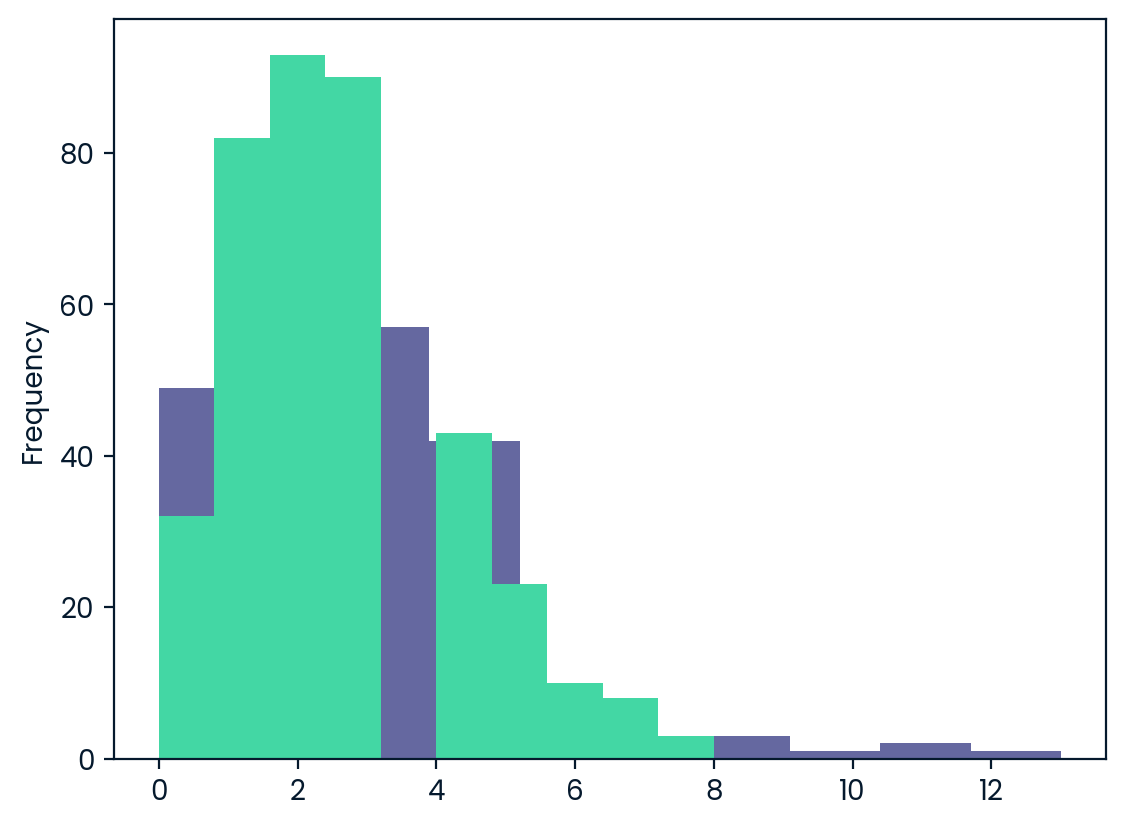

In [42]:
df_women['goals_scored'].plot(kind='hist');
df_men['goals_scored'].plot(kind='hist');

In [43]:
# Calculation of mean goal scores for women and determination of normality
print(f"The mean of goals scored for women is {df_women['goals_scored'].mean()}.")
statistic, p_value = shapiro(df_women['goals_scored'])
print(f"Statistic: {statistic} and P value: {p_value}")

alpha = 0.01
if p_value > alpha:
    print("The data looks normally distributed (fail to reject H0)", '\n')
else:
    print("The data does not look normally distributed (reject H0)", '\n')

The mean of goals scored for women is 2.98.
Statistic: 0.8491013050079346 and P value: 3.8905201759850683e-13
The data does not look normally distributed (reject H0) 



In [44]:
from scipy.stats import shapiro

# Assuming df_men is a DataFrame and 'goals_scored' is a column in it
print(f"The mean of goals scored for women is {df_men['goals_scored'].mean()}.")
statistic, p_value = shapiro(df_men['goals_scored'])
print(f"Statistic: {statistic} and P value: {p_value}")

alpha = 0.01
if p_value > alpha:
    print("The data looks normally distributed (fail to reject H0)", '\n')
else:
    print("The data does not look normally distributed (reject H0)")


The mean of goals scored for women is 2.5130208333333335.
Statistic: 0.9266489744186401 and P value: 8.894154401688226e-13
The data does not look normally distributed (reject H0)


Performing the hypothesis test

In [45]:
# using pingouin
result = pg.mwu(df_women['goals_scored'], df_men['goals_scored'], alternative="greater")
p_val = result['p-val'].values[0]

alpha = 0.01
if p_val > alpha:
    print("The null hypothesis cannot be rejected (There is no significant difference between goal scores of men and women (p>0.1)).")
else:
    print("The null hypothesis is rejected (There is a significant difference between goal scores of men and women (p<0.1)).")

The null hypothesis is rejected (There is a significant difference between goal scores of men and women (p<0.1)).


In [46]:
# using SciPy
statistic, p_value = stats.mannwhitneyu(df_women['goals_scored'], df_men['goals_scored'], alternative="greater")

alpha = 0.01
if p_value > alpha:
    print("The null hypothesis cannot be rejected (There is no significant difference between goals scores of men and women (p>0.1)).")
else:
    print("The null hypothesis is rejected (There is a significant difference between goals scores of men and women (p<0.1)).")

The null hypothesis is rejected (There is a significant difference between goals scores of men and women (p<0.1)).


Interpreting the hypothesis test result

In [47]:
if p_val <= 0.01:
    result = 'reject'
else:
    result = 'fail to reject'

result_dict = {"p_val": p_val, "result": result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}
